In [37]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

import tldextract
from urllib.parse import urlparse
from googlesearch import search


from imblearn.under_sampling import NearMiss

# **1. Import the dataset**

In [3]:
path = '../data/phishing_site_urls.csv'
phishing_data = pd.read_csv(path)
phishing_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [4]:
phishing_data['Label'].value_counts()

Label
good    392924
bad     156422
Name: count, dtype: int64

In [5]:
le = LabelEncoder()
phishing_data["Label"] = le.fit_transform(phishing_data["Label"])

In [6]:
phishing_data['Label'].value_counts()

Label
1    392924
0    156422
Name: count, dtype: int64

In [4]:

# phishing_data = data.sample(n=25000, random_state =42).copy() #Sample of n websites
# phishing_data = phishing_data.reset_index(drop=True)
# phishing_data.head()

In [7]:
phishing_data.describe()

,Label
count,549346.000000
mean,0.715258
std,0.451292
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
phishing_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0
3,mail.printakid.com/www.online.americanexpress....,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,0


# **2. Feature extraction**

In [8]:
def letter_count(url):
    letters = []
    for i in url:
        if i.isalpha():
            letters.append(i)
    return letters


def digit_count(url):
    digits = []
    for i in url:
        if i.isnumeric():
            digits.append(i)
    return digits

def google_index(url):
    site = search(url, 5)
    return True if site else False

In [9]:
def extract_features(url):
    parsed_url = urlparse(url)
    # Extract domain features using tldextract
    domain_extract = tldextract.extract(url)
    domain = domain_extract.domain
    suffix = domain_extract.suffix
    letters = letter_count(url)
    digits = digit_count(url)
    google_searchable = google_index(url)

    # Features to extract
    features = {
        'url_length': len(url), #Length of URL
        'domain_length': len(domain), #Length of domain
        'dot_count': domain.count('.'), #Number of dots in the domain
        'is_ip_address': domain.replace('.', '').isdigit(), #IP address in the domain
        'special_chars_in_domain': any(char.isnumeric() or not char.isalnum() for char in domain), #Presence of special characters in the domain
        'tld_length': len(suffix), #Length of the top-level domain (e.g., '.com', '.org')
        'hyphen_in_domain': '-' in domain, #Presence of hyphen in the domain
        'at_symbol': '@' in parsed_url.netloc, #Presence of '@' in the URL
        'https': 'https' in parsed_url.scheme, #Check if site is secure with https
        'letter_count': len(letters), #Length of alphabets in url
        'digit_count': len(digits), #Length of numbers(digits) in url
        'google_search': google_searchable
    }

    return features

# **3. Data Preprocessing**

In [10]:
phishing_data['Label'].value_counts()

Label
1    392924
0    156422
Name: count, dtype: int64

From the above result, dataset is imbalanced. good class is almost twice the bad class. Let's undersample the good class since our dataset is large.

In [11]:
y_labels = phishing_data["Label"] 
phishing_data['Features'] = phishing_data["URL"].apply(extract_features) 
data_features = pd.json_normalize(phishing_data['Features'])
phishing_data = pd.concat([phishing_data, data_features], axis=1)
x_features = phishing_data.drop(["Label","URL","Features"], axis=1)

In [13]:
nm1 = NearMiss(version=1)
x_features, y_labels = nm1.fit_resample(x_features, y_labels)

In [36]:
x_features.to_csv('../data/x_features.csv')

In [14]:
y_labels.value_counts()

Label
0    156422
1    156422
Name: count, dtype: int64

In [12]:
x_features.head()

,url_length,domain_length,dot_count,is_ip_address,special_chars_in_domain,tld_length,hyphen_in_domain,at_symbol,https,letter_count,...,dot_count,is_ip_address,special_chars_in_domain,tld_length,hyphen_in_domain,at_symbol,https,letter_count,digit_count,google_search
13550,29.0,8.0,0.0,False,True,2.0,True,False,False,22.0,...,0.0,False,False,2.0,False,False,False,25.0,25.0,True
514835,27.0,14.0,3.0,True,True,0.0,False,False,False,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531588,23.0,6.0,0.0,False,True,3.0,False,False,False,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30578,93.0,8.0,0.0,False,False,3.0,False,False,False,52.0,...,0.0,False,False,3.0,False,False,False,44.0,0.0,True
504381,55.0,7.0,0.0,False,False,3.0,False,False,False,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
phishing_data.isna().sum()

URL                        0
Label                      0
Features                   0
url_length                 0
domain_length              0
dot_count                  0
is_ip_address              0
special_chars_in_domain    0
tld_length                 0
hyphen_in_domain           0
at_symbol                  0
https                      0
letter_count               0
digit_count                0
google_search              0
dtype: int64

In [16]:
x_features.describe()

,url_length,domain_length,dot_count,tld_length,letter_count,digit_count
count,312844.000000,312844.000000,312844.000000,312844.000000,312844.000000,312844.000000
mean,47.580903,10.322592,0.074942,2.957011,36.858473,4.540356
std,53.889648,4.412560,0.468198,0.912409,37.026950,14.632241
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,7.000000,0.000000,3.000000,20.000000,0.000000
50%,34.000000,9.000000,0.000000,3.000000,28.000000,0.000000
75%,49.000000,13.000000,0.000000,3.000000,40.000000,2.000000
max,2307.000000,121.000000,3.000000,12.000000,2141.000000,545.000000


In [17]:
y_labels.head()

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int64

In [12]:
y_labels.value_counts()

Label
good    392924
bad     156422
Name: count, dtype: int64

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size = 0.3, random_state = 42)

In [19]:
#class_weights = {'good': 1, 'bad': 3} 
models = {'Logistic Regression': LogisticRegression(), 
          'Decision Tree': DecisionTreeClassifier(max_depth = 5),
          'Random Forest': RandomForestClassifier(max_depth=5, n_jobs=-1)
          }

# **4. Model Training**

In [28]:
train_results = []
test_results = []

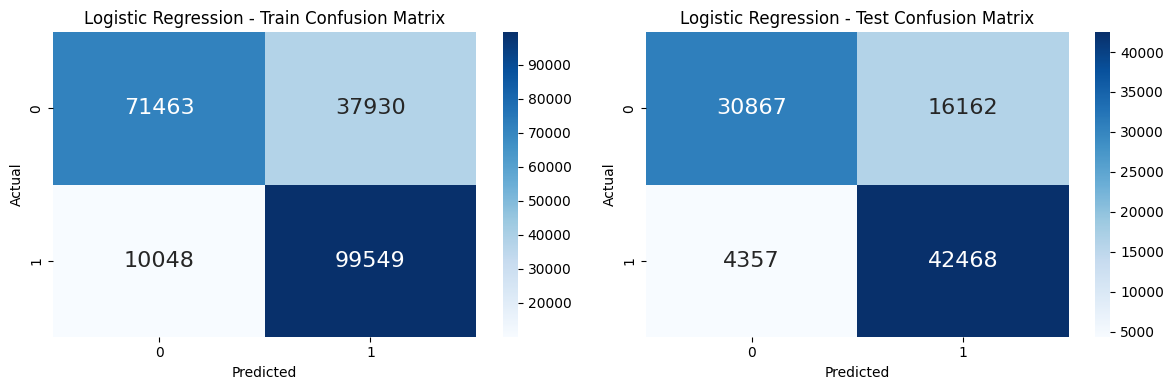

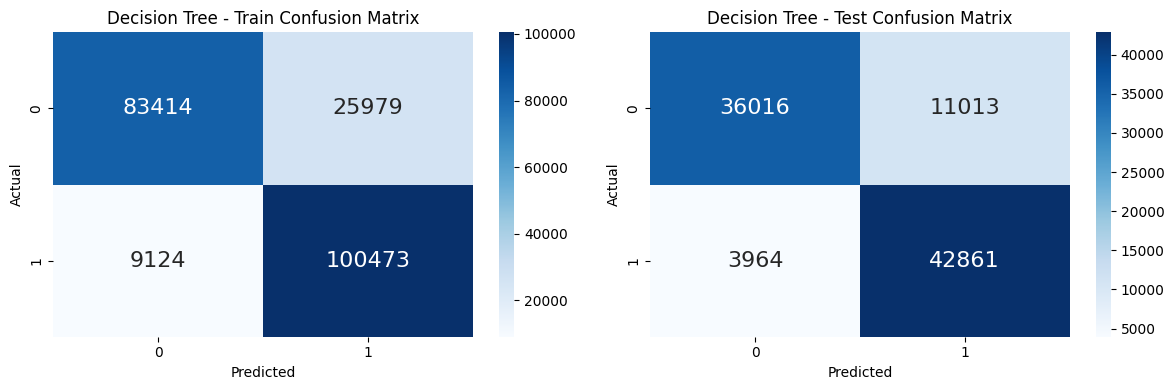

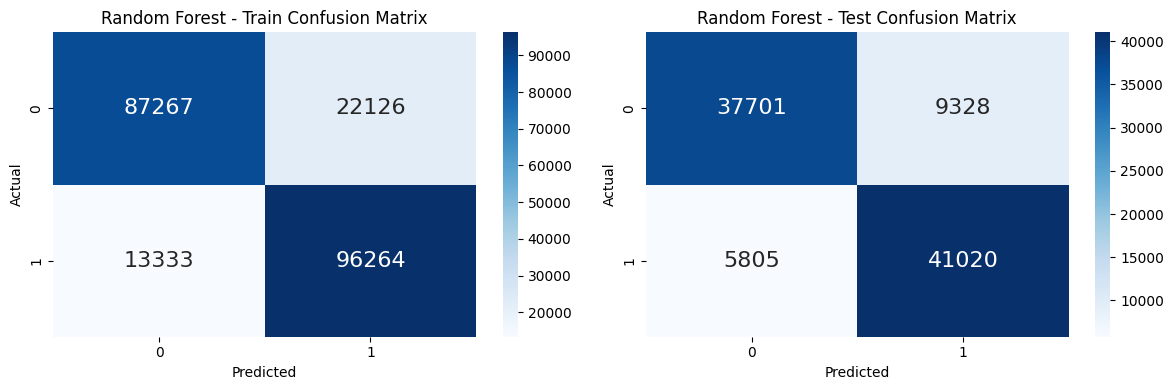

In [29]:
for name, model in models.items():
    model.fit(x_train, y_train)
    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    # Compute confusion matrices
    train_cm = confusion_matrix(y_train, y_train_predict)
    test_cm = confusion_matrix(y_test, y_test_predict)
    
    # Plot confusion matrices using Seaborn
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'{name} - Train Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 2, 2)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'{name} - Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    train_report = classification_report(y_train, y_train_predict, output_dict=True)
    test_report = classification_report(y_test, y_test_predict, output_dict=True)
    train_results.append({'Machine Learning Model': name,
                    'Accuracy': round(train_report['accuracy'],3),
                    'Precision': round(train_report['weighted avg']['precision'],3),
                    'Recall': round(train_report['weighted avg']['recall'],3),
                    'F1 Score': round(train_report['weighted avg']['f1-score'],3),
                    'Support': round(train_report['weighted avg']['support'],3)})
    test_results.append({'Machine Learning Model': name,
                    'Accuracy': round(test_report['accuracy'],3),
                    'Precision': round(test_report['weighted avg']['precision'],3),
                    'Recall': round(test_report['weighted avg']['recall'],3),
                    'F1 Score': round(test_report['weighted avg']['f1-score'],3),
                    'Support': round(test_report['weighted avg']['support'],3)})

In [30]:
# Convert the results into DataFrames
train_results = pd.DataFrame(train_results)
test_results = pd.DataFrame(test_results)

In [31]:
sorted_train_results = train_results.sort_values(by='Accuracy', ascending=False)
sorted_test_results = test_results.sort_values(by='Accuracy', ascending=False)
print(f'Training Data Report:\n {sorted_train_results}')
print(f'\nTesting Data Report:\n {sorted_test_results}')

Training Data Report:
   Machine Learning Model  Accuracy  Precision  Recall  F1 Score   Support
1          Decision Tree     0.840      0.848   0.840     0.839  218990.0
2          Random Forest     0.838      0.840   0.838     0.838  218990.0
0    Logistic Regression     0.781      0.800   0.781     0.777  218990.0

Testing Data Report:
   Machine Learning Model  Accuracy  Precision  Recall  F1 Score  Support
1          Decision Tree     0.840      0.848   0.840     0.840  93854.0
2          Random Forest     0.839      0.841   0.839     0.839  93854.0
0    Logistic Regression     0.781      0.800   0.781     0.778  93854.0


# **5. Model Comparison**
## 5.1. Metric Comparison 

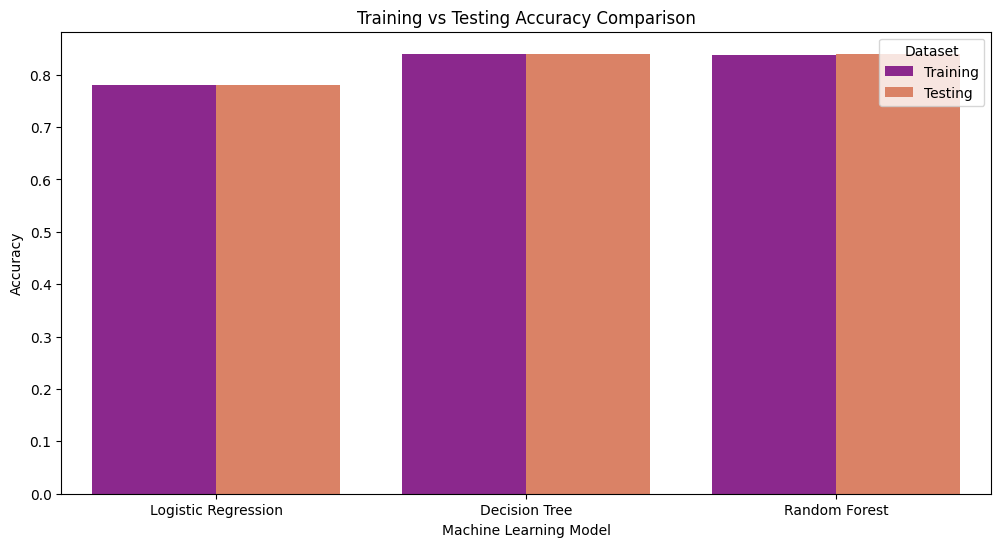

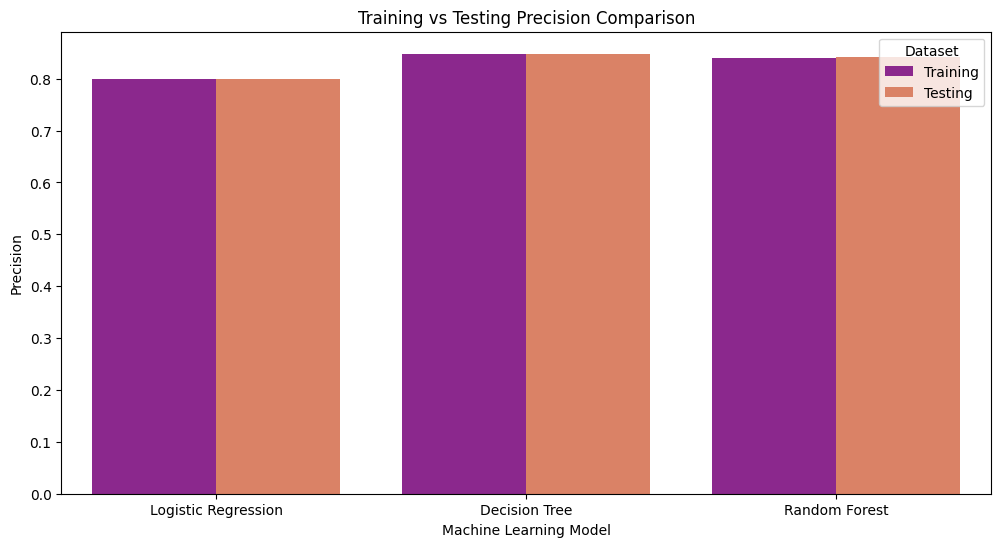

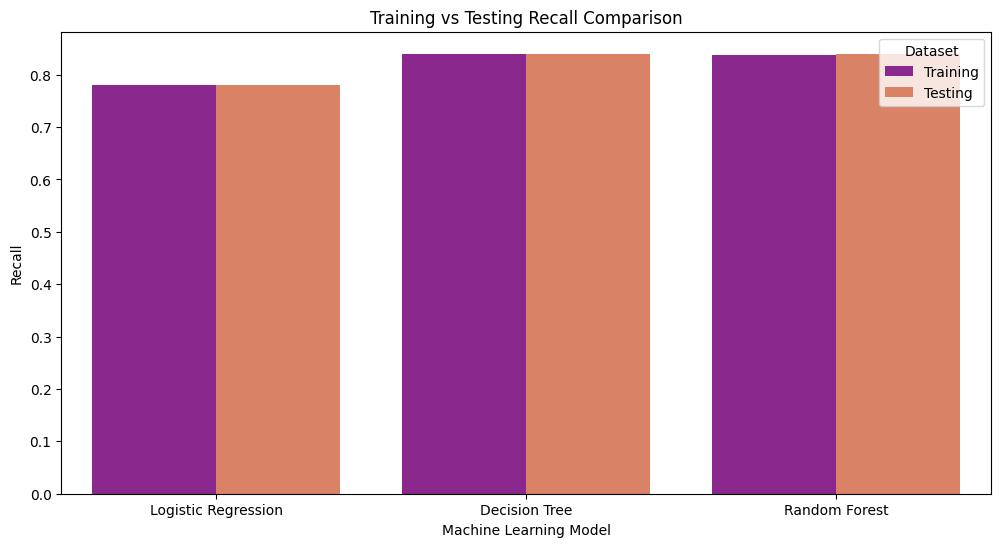

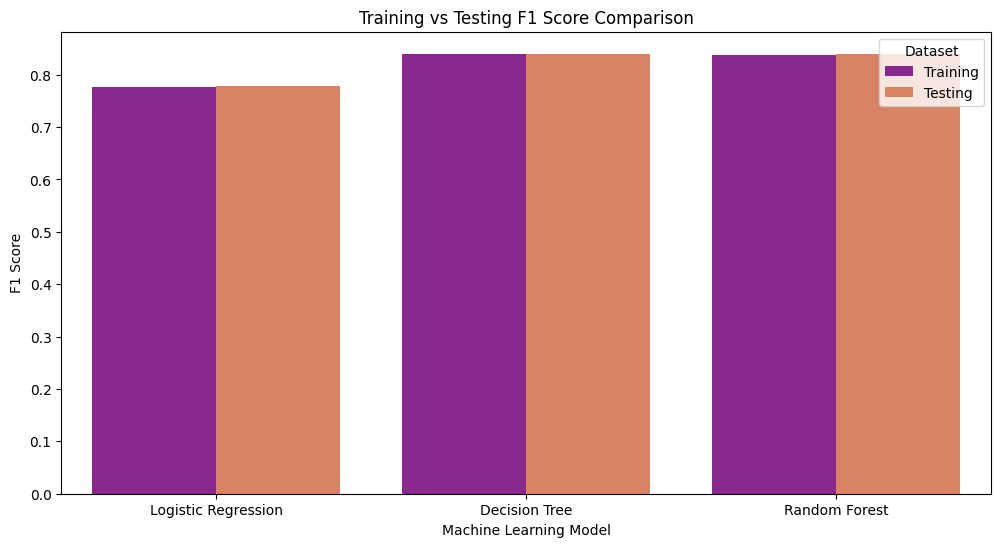

In [32]:
# Create a new column in training and testing DataFrames to define
train_results['Dataset'] = 'Training'
test_results['Dataset'] = 'Testing'
# Create a new DataFrame which is a concatenation of both sets
all_results = pd.concat([train_results, test_results], ignore_index = True)
#Remove the Support column from the DataFrame
results_without_support = all_results.drop('Support', axis=1, errors='ignore')
# Melt the DataFrame for easier plotting
results_melted = results_without_support.melt(id_vars=['Machine Learning Model', 'Dataset'], var_name='Metric', value_name='Score')

unique_metrics = results_melted['Metric'].unique()

for metric in unique_metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Machine Learning Model', 
                y='Score',
                data=results_melted[results_melted['Metric'] == metric],
                hue='Dataset',
                palette='plasma')
    plt.title(f'Training vs Testing {metric} Comparison')
    plt.xlabel('Machine Learning Model')
    plt.ylabel(metric)
    plt.show()

## 5.2. All Metrics

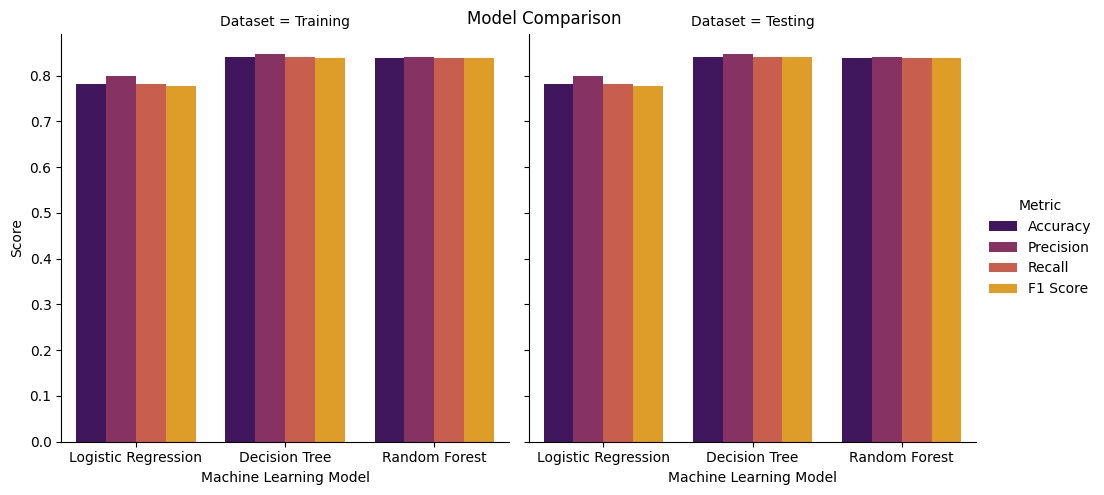

In [33]:
grid = sns.catplot(x='Machine Learning Model', 
            y='Score', 
            data=results_melted,
            hue='Metric',
            col='Dataset',
            errorbar=None,
            palette='inferno',
            kind='bar')
grid.fig.suptitle('Model Comparison')
grid.set_axis_labels('Machine Learning Model', 'Score')
plt.show()

# **6. Model Output**

In [35]:
import pickle
for name, model in models.items():
    name = name.replace(' ','_') + '.h5'
    with open(f'../trained_model/{name}','wb') as file:
        pickle.dump(model, file)

In [27]:
from joblib import load

# Load the model from the .h5 file
model = load('../trained_model/Random_Forest.h5')



In [35]:
def model_predict(url):
   
    formated_url = extract_features(url)
    prediction = model.predict(np.array(list(formated_url.values())).reshape(1, -1))[0]
    return prediction

model_predict('nobell.it/70ffb52d079109dca5664cce6f317373782/')

/Users/honesty/Desktop/Sunday/all_works/UNIPORT/ugochi/phising_urls/ven/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


'bad'